In [ ]:
import tensorflow

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [ ]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3))

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x)
x= Dense(512,activation='relu')(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(4,activation='softmax')(x) #FC-layer

29084464/29084464 [==============================] - 2s 0us/step


In [ ]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
for layer in model.layers[:-8]:
    layer.trainable=False

for layer in model.layers[-8:]:
    layer.trainable=True

In [ ]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 134, 134, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 64, 64, 64)   9408        ['zero_padding2d[0][0]']         
                                                                                                  
 conv1/bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1/conv[0][0]']         

In [ ]:
import os
import random
import cv2
from tensorflow.keras.preprocessing.image import img_to_array

data = []
labels = []
random.seed(42)
imagePaths = sorted(list(os.listdir("/content/drive/MyDrive/archive-eyes")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path = sorted(list(os.listdir(os.path.join("/content/drive/MyDrive/archive-eyes", img))))
    for i in path:
        image = cv2.imread(os.path.join("/content/drive/MyDrive/archive-eyes", img, i))
        image = cv2.resize(image, (128, 128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)


['glaucoma', 'diabetic_retinopathy', 'normal', 'cataract']


In [ ]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 0 1 0]


In [ ]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(3373, 128, 128, 3) (844, 128, 128, 3)


In [ ]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=128),
               steps_per_epoch=xtrain.shape[0] //128,
               epochs=100,
               verbose=2,
               callbacks=[anne, checkpoint],
               validation_data=(xtrain, ytrain))

Epoch 1/100

Epoch 1: val_loss improved from inf to 1.17805, saving model to model.h5
26/26 - 47s - loss: 1.1803 - accuracy: 0.6330 - val_loss: 1.1780 - val_accuracy: 0.5491 - lr: 0.0010 - 47s/epoch - 2s/step
Epoch 2/100

Epoch 2: val_loss improved from 1.17805 to 1.12544, saving model to model.h5
26/26 - 20s - loss: 0.8097 - accuracy: 0.7211 - val_loss: 1.1254 - val_accuracy: 0.5277 - lr: 0.0010 - 20s/epoch - 760ms/step
Epoch 3/100

Epoch 3: val_loss improved from 1.12544 to 0.73096, saving model to model.h5
26/26 - 19s - loss: 0.6767 - accuracy: 0.7461 - val_loss: 0.7310 - val_accuracy: 0.6801 - lr: 0.0010 - 19s/epoch - 723ms/step
Epoch 4/100

Epoch 4: val_loss improved from 0.73096 to 0.61454, saving model to model.h5
26/26 - 20s - loss: 0.6602 - accuracy: 0.7578 - val_loss: 0.6145 - val_accuracy: 0.7622 - lr: 0.0010 - 20s/epoch - 771ms/step
Epoch 5/100

Epoch 5: val_loss did not improve from 0.61454
26/26 - 19s - loss: 0.5968 - accuracy: 0.7667 - val_loss: 0.6207 - val_accuracy: 0.

In [ ]:
ypred = model.predict(xtest)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(ytest[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)

    total += 1

print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

27/27 [==============================] - 5s 85ms/step
Total-test-data; 844 	accurately-predicted-data: 739 	 wrongly-predicted-data:  105
Accuracy: 87.559 %


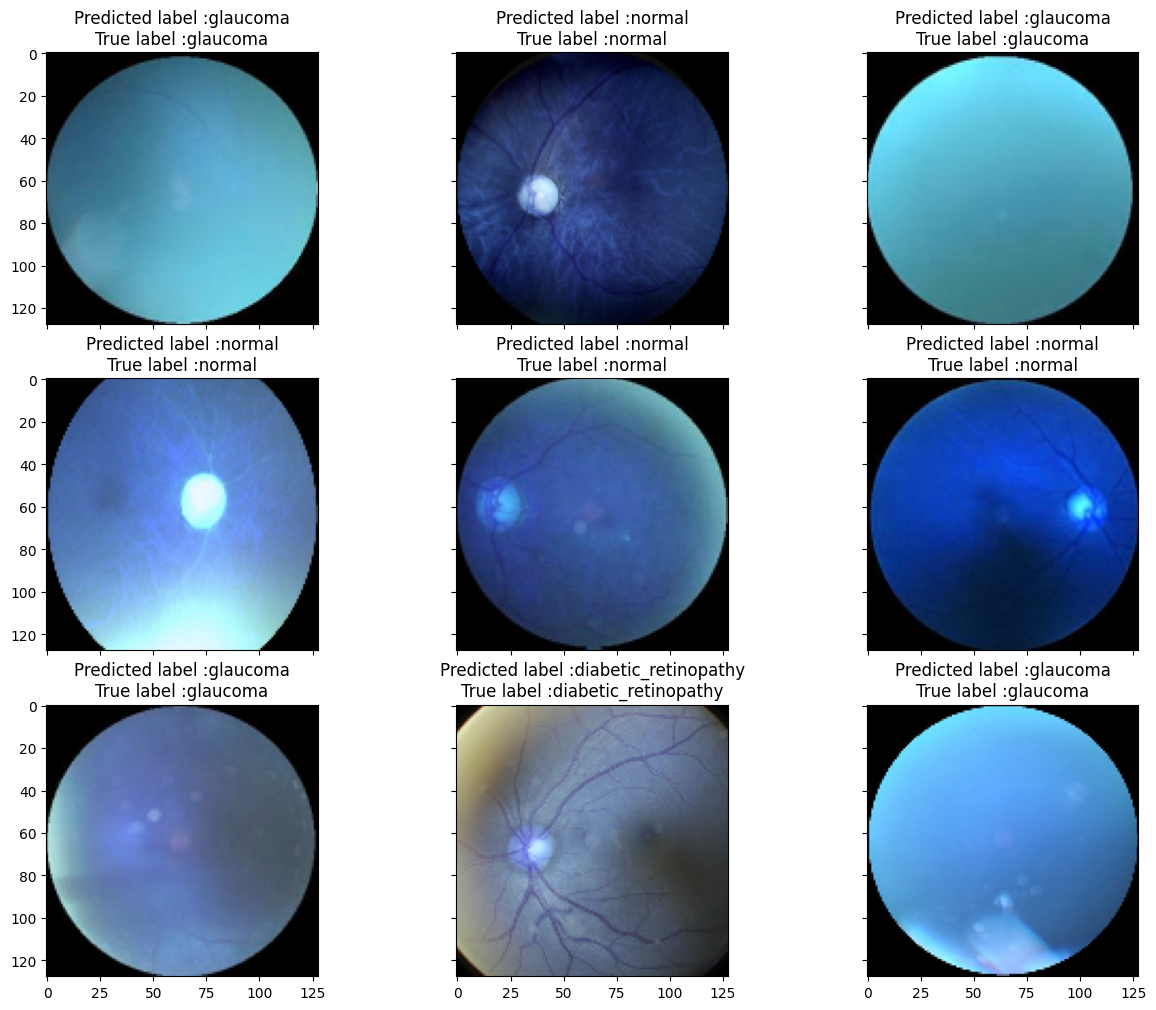

In [ ]:
label=['glaucoma', 'diabetic_retinopathy', 'normal', 'cataract']
imidx = random.sample(accurateindex, k=9)# replace with 'wrongindex'

nrows = 3
ncols = 3
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(xtest[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(ytest[imidx[n]])]))
            n += 1

plt.show()